In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import os
from transformers import AutoModelForCausalLM, AutoConfig, AutoModel
from peft import LoraConfig, get_peft_model
from tqdm import tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ViewportCSVDataset(Dataset):
    def __init__(self, file_path, seq_length=2, pred_length=4):
        raw_data = np.loadtxt(file_path, delimiter=',')  # shape: [T, 4]
        self.full_data = raw_data

        self.mean = raw_data.mean(axis=0)
        self.std = raw_data.std(axis=0)
        self.data = (raw_data - self.mean) / self.std

        self.samples = []
        for i in range(len(self.data) - seq_length - pred_length):
            x = self.data[i:i+seq_length]        # [2,4]
            y = self.data[i+seq_length:i+seq_length+pred_length]  # [4,4]
            self.samples.append((x, y))

        print(f" Total samples in {file_path}: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.FloatTensor(x), torch.FloatTensor(y)

    def denormalize(self, data):
        return data * self.std + self.mean

In [ ]:
def load_nested_csv_folders(base_path):
    print(f"🔍 Searching in: {base_path}")
    datasets = []
    for root, dirs, files in os.walk(base_path):
        if files and all(f.endswith(".csv") for f in files):
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    ds = ViewportCSVDataset(file_path)
                    datasets.append(ds)
                except Exception as e:
                    print(f"❌ Error loading {file_path}: {str(e)}")
    print(f"✅ Total datasets loaded: {len(datasets)}")
    return ConcatDataset(datasets)

In [ ]:
class ViewportPredictorLLaMA(nn.Module):
    def __init__(self, llama_model="TinyLlama/TinyLlama-1.1B-Chat-v1.0", seq_len=2):
        super().__init__()
        print("🔧 Initializing TinyLLaMA model and CNN encoder")

        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * (seq_len - 1), 256),
            nn.ReLU()
        )

        config = AutoConfig.from_pretrained(llama_model)
        config.use_cache = False
        self.llama = AutoModel.from_pretrained(llama_model, config=config)

        for param in self.llama.parameters():
            param.requires_grad = False

        print("✅ TinyLLaMA base model loaded and frozen")

        lora_config = LoraConfig(
            r=8,
            lora_alpha=32,
            target_modules=["q_proj", "v_proj"],
            lora_dropout=0.05,
            bias="none",
            inference_mode=False
        )
        self.llama = get_peft_model(self.llama, lora_config)
        print("✅ LoRA applied to TinyLLaMA")

        self.input_proj = nn.Linear(256, config.hidden_size)
        self.output_proj = nn.Linear(config.hidden_size, 16)
        print("✅ Model ready")

    def forward(self, x):
        x = x.transpose(1, 2)
        encoded = self.encoder(x)

        projected = self.input_proj(encoded).unsqueeze(1)
        llama_out = self.llama.model(inputs_embeds=projected)
        final = llama_out.last_hidden_state[:, -1, :]


        output = self.output_proj(final)
        return output.view(-1, 4, 4)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=3, lr=1e-4):
    print("🚀 Starting training loop")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        print(f"🧪 Training epoch {epoch+1}/{epochs}")
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"✅ Epoch {epoch+1} Train Loss: {train_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0.0
        print(f"🔎 Validating epoch {epoch+1}")
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        print(f"📊 Epoch {epoch+1} Val Loss: {val_loss / len(val_loader):.4f}")

    print("🏁 Training complete")
    return model

In [ ]:
data_path = "/content/drive/MyDrive/data"
print(f"📂 Dataset path: {data_path}")
dataset = load_nested_csv_folders(data_path)
print(f"📦 Total samples: {len(dataset)}")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"🧹 Train size: {len(train_dataset)} | Val size: {len(val_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

📂 Dataset path: /content/drive/MyDrive/data
🔍 Searching in: /content/drive/MyDrive/data
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user11.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user65.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user6.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user39.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user49.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user77.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user32.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user5.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_user64.csv: 294
✅ Total samples in /content/drive/MyDrive/data/Jin2022/video1/5Hz/simple_5Hz_

In [ ]:
model = ViewportPredictorLLaMA()

🔧 Initializing TinyLLaMA model and CNN encoder
✅ TinyLLaMA base model loaded and frozen
✅ LoRA applied to TinyLLaMA
✅ Model ready


In [ ]:
model = train_model(model, train_loader, val_loader)

🚀 Starting training loop
🧪 Training epoch 1/3


Epoch 1: 100%|██████████| 12773/12773 [20:37<00:00, 10.32it/s]


✅ Epoch 1 Train Loss: 0.2251
🔎 Validating epoch 1
📊 Epoch 1 Val Loss: 0.2230
🧪 Training epoch 2/3


Epoch 2: 100%|██████████| 12773/12773 [20:23<00:00, 10.44it/s]


✅ Epoch 2 Train Loss: 0.1992
🔎 Validating epoch 2
📊 Epoch 2 Val Loss: 0.2013
🧪 Training epoch 3/3


Epoch 3: 100%|██████████| 12773/12773 [20:29<00:00, 10.39it/s]


✅ Epoch 3 Train Loss: 0.1919
🔎 Validating epoch 3
📊 Epoch 3 Val Loss: 0.2033
🏁 Training complete


In [ ]:
x_sample, _ = next(iter(train_loader))
x_sample = x_sample.to(device)
print("🔮 Inference sample input shape:", x_sample.shape)
output = model(x_sample)
print("🎯 Final prediction shape:", output.shape)


🔮 Inference sample input shape: torch.Size([4, 2, 4])
🎯 Final prediction shape: torch.Size([4, 4, 4])


🔎 Evaluating model on validation data...
📉 MSE: 0.2034
📉 MAE: 0.2109


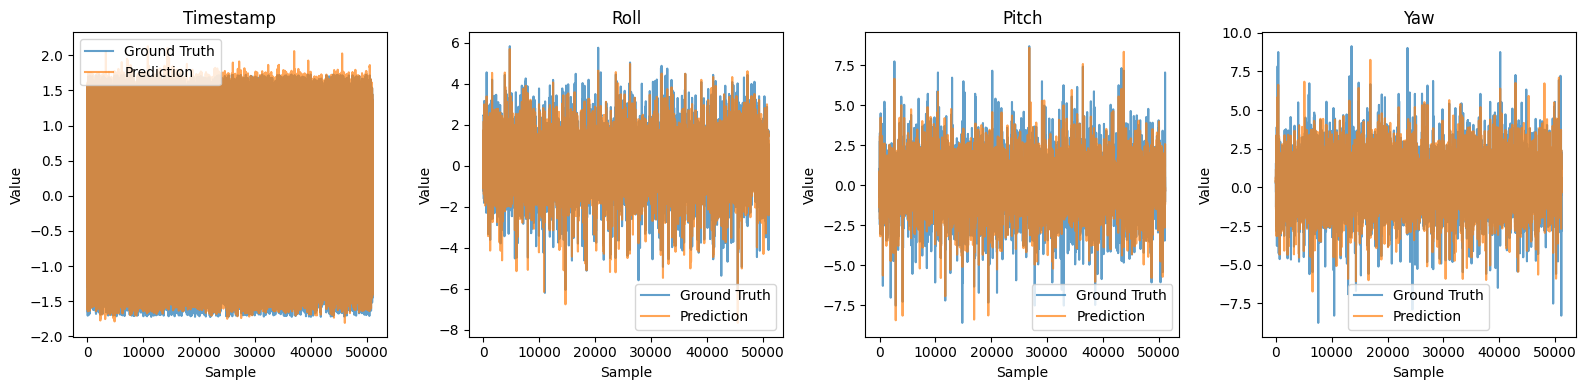

(0.20335307717323303, 0.21093794703483582)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, data_loader, device):
    print("🔎 Evaluating model on validation data...")
    model.eval()

    all_preds = []
    all_truths = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)  # [B, 4, 4]
            all_preds.append(pred.cpu().numpy())
            all_truths.append(y.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)   # [N, 4, 4]
    truths = np.concatenate(all_truths, axis=0) # [N, 4, 4]

    # Flatten for metrics: [N*4, 4]
    preds_flat = preds.reshape(-1, 4)
    truths_flat = truths.reshape(-1, 4)

    mse = mean_squared_error(truths_flat, preds_flat)
    mae = mean_absolute_error(truths_flat, preds_flat)

    print(f"📉 MSE: {mse:.4f}")
    print(f"📉 MAE: {mae:.4f}")

    # Optional: plot predicted vs ground truth for each feature
    feature_names = ["Timestamp", "Roll", "Pitch", "Yaw"]
    plt.figure(figsize=(16, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.plot(truths_flat[:, i], label="Ground Truth", alpha=0.7)
        plt.plot(preds_flat[:, i], label="Prediction", alpha=0.7)
        plt.title(feature_names[i])
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.legend()
    plt.tight_layout()
    plt.show()

    return mse, mae


evaluate_model(model, val_loader, device)